In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import koreanize_matplotlib
import os
import glob

from tensorflow.keras import models, Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

# 📍 Mask man 찾기

In [ ]:
import zipfile

# 압축파일을 관리
content_zip = zipfile.ZipFile("/content/drive/MyDrive/제로베이스/스터디노트/18주차/archive_.zip")
content_zip.extractall("/content/drive/MyDrive/제로베이스/스터디노트/18주차")

content_zip.close()

In [3]:
# 파일 정리 방법
path = "/content/drive/MyDrive/제로베이스/스터디노트/18주차/Face Mask Dataset"
dataset = {"image_path": [], "mask_status": [], "where": []}

for where in os.listdir(path):
  for status in os.listdir(path + "/" + where):
    for image in glob.glob(path + "/" + where + "/" + status + "/" + "*.png"):
      dataset["image_path"].append(image)
      dataset["mask_status"].append(status)
      dataset["where"].append(where)

In [4]:
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
1,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
2,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
3,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
4,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test


In [5]:
dataset

,image_path,mask_status,where
0,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
1,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
2,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
3,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
4,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Test
...,...,...,...
11787,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Validation
11788,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Validation
11789,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Validation
11790,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Validation


With Mask:  5909
Without Mask:  5883


<Axes: xlabel='mask_status', ylabel='count'>

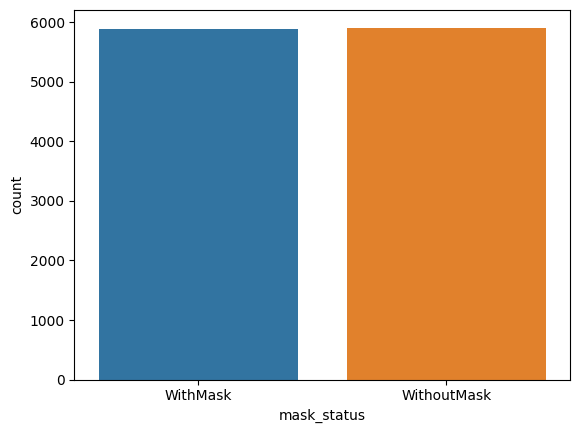

In [6]:
print("With Mask: ", (dataset["mask_status"].value_counts()[0]))
print("Without Mask: ", (dataset["mask_status"].value_counts()[1]))

sns.countplot(x=dataset["mask_status"])

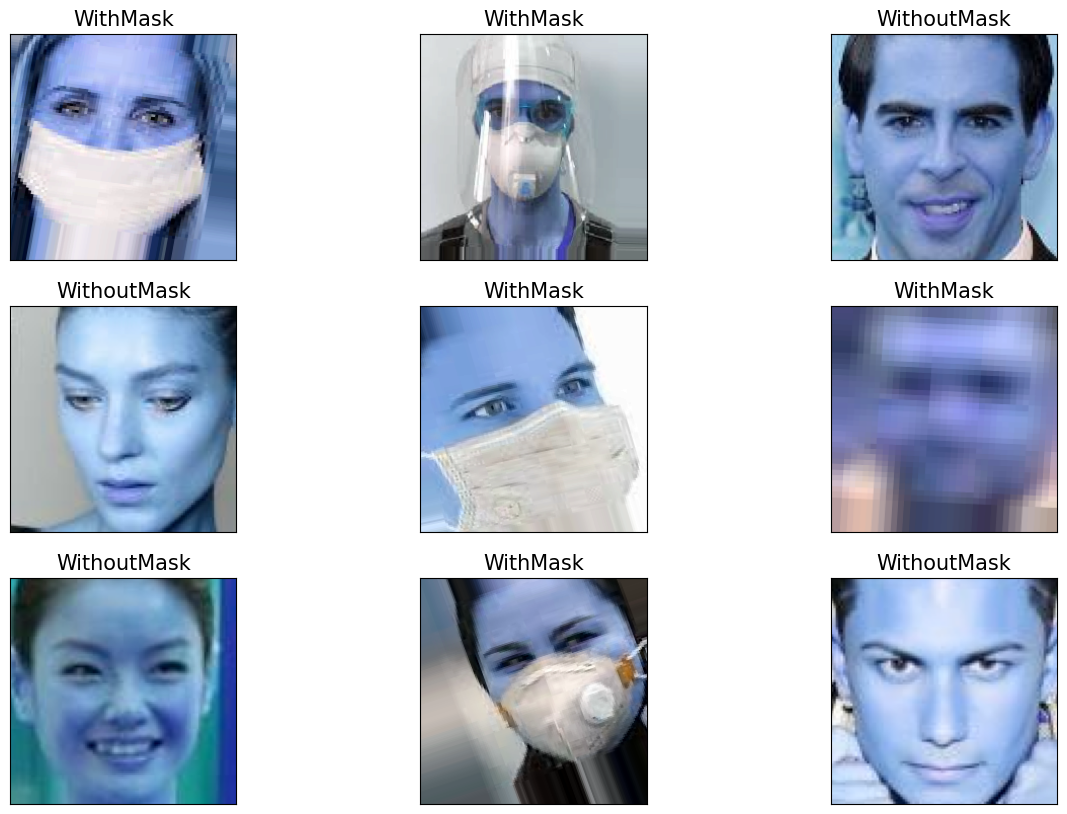

In [7]:
# 랜덤하게 어떤 그림들이 있는지 보기

import cv2

plt.figure(figsize=(15, 10))
for i in range(9):
  random = np.random.randint(1, len(dataset))
  plt.subplot(3, 3, i+1)
  plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
  plt.title(dataset.loc[random, "mask_status"], size=15)
  plt.xticks([])
  plt.yticks([])

plt.show()

In [8]:
dataset["where"].value_counts()

Train         10000
Test            992
Validation      800
Name: where, dtype: int64

In [9]:
# 데이터 분리
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
val_df = dataset[dataset["where"] == "Validation"]

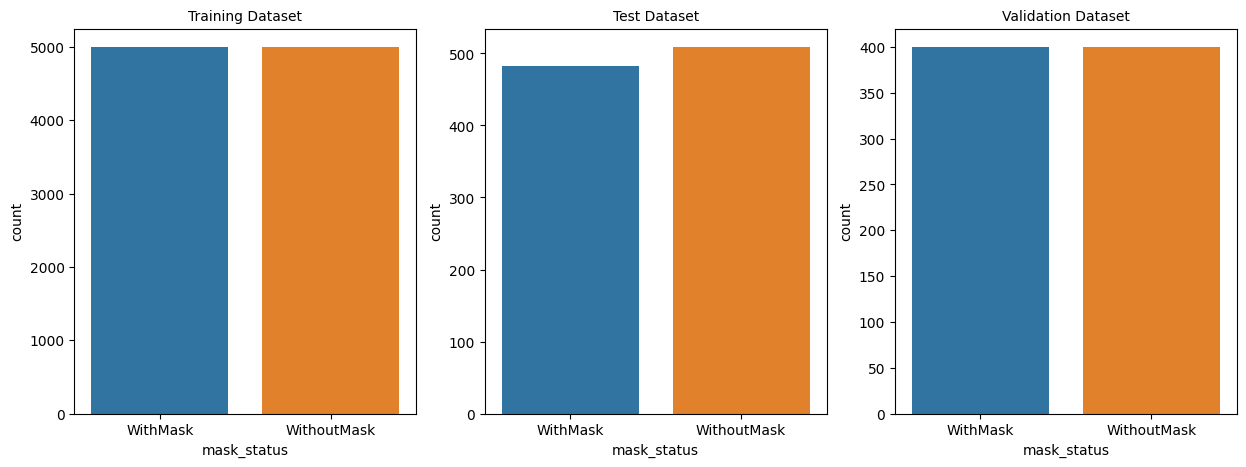

In [10]:
# 데이터 확인
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train_df["mask_status"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["mask_status"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=val_df["mask_status"])
plt.title("Validation Dataset", size=10)

plt.show()

In [11]:
# index 정리
train_df = train_df.reset_index().drop("index", axis=1)
train_df

,image_path,mask_status,where
0,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Train
1,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Train
2,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Train
3,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Train
4,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithMask,Train
...,...,...,...
9995,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Train
9996,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Train
9997,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Train
9998,/content/drive/MyDrive/제로베이스/스터디노트/1...,WithoutMask,Train


In [12]:
# 데이터 전처리
data = []
image_size = 150

for i in range(len(train_df)):
  img_path = train_df["image_path"][i]
  img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

  # 이미지가 제대로 로드되었는지 확인
  if img_array is None:
      print(f"Error loading image {img_path}")
      continue  # 다음 이미지로 넘어갑니다.

  new_image_array = cv2.resize(img_array, (image_size, image_size))

  if train_df["mask_status"][i] == "WithMask":
    data.append([new_image_array, 1])

  else:
    data.append([new_image_array, 0])

Error loading image /content/drive/MyDrive/제로베이스/스터디노트/18주차/Face Mask Dataset/Train/WithMask/1063.png


In [13]:
# Data 확인
data[0]

[array([[ 28,  28,  28, ...,  14,  14,  14],
        [ 28,  28,  28, ...,  14,  14,  14],
        [ 28,  28,  28, ...,  14,  14,  14],
        ...,
        [ 38,  38,  38, ..., 115, 128, 128],
        [ 38,  38,  38, ..., 113, 128, 128],
        [ 38,  38,  38, ..., 110, 128, 128]], dtype=uint8),
 1]

In [14]:
data[1]

[array([[ 55,  55,  55, ...,  99, 107, 114],
        [ 54,  54,  54, ...,  99, 112, 114],
        [ 54,  54,  54, ..., 103, 114, 114],
        ...,
        [ 39,  34,  33, ...,  22,  22,  22],
        [ 38,  33,  33, ..., 112,  59,  38],
        [ 36,  33,  33, ..., 207, 197, 176]], dtype=uint8),
 1]

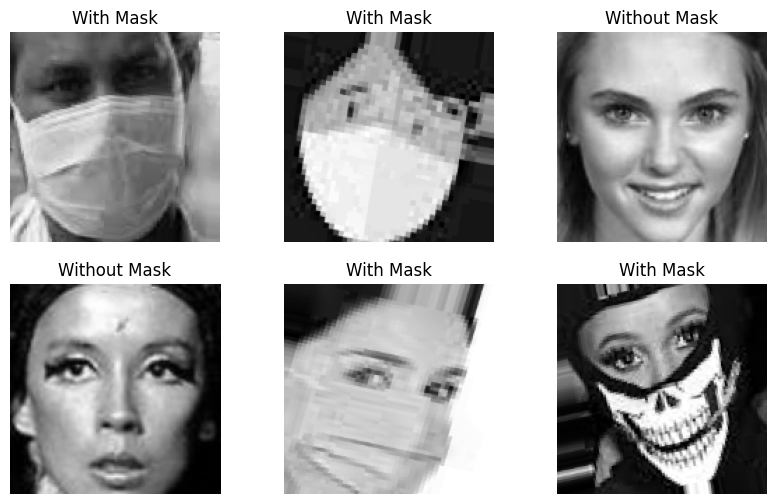

In [15]:
np.random.shuffle(data)

fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for row in range(2):
  for col in range(3):
    image_index = row * 100 + col

    ax[row, col].axis("off")
    ax[row, col].imshow(data[image_index][0], cmap="gray")

    if data[image_index][1] == 0:
      ax[row, col].set_title("Without Mask")
    else:
      ax[row, col].set_title("With Mask")

In [16]:
# 데이터 정의 및 나누기
X = []
y = []

for image in data:
  X.append(data[0])
  y.append(data[1])

X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

<ipython-input-16-3e6fc4835265>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-16-3e6fc4835265>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [ ]:
# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu", input_shape=(150, 150, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1)),
    layers.Conv2D(64, (2, 2), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(10000, activation="relu"),
    layers.Dense(10, activation="sigmoid")
])

model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
# 모델 학습
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val[2], 1)
hist = model.fit(X_train, y_train, epochs=4, batch_size=32)

In [ ]:
# 성능확인
model.evaluate(X_val, y_val)

In [ ]:
prediction = (model.predict(X_val) > 0.5).astype("int32")

print(classification_report(y_val), prediction)
print(confusion_matrix(y_val), prediction)

In [ ]:
# 틀린 것만 추리기
wrong_result = []

for n in range(0, len(y_val)):
  if prediction[n] != y_val[n]:
    wrong_result.append(n)

len(wrong_result)

In [ ]:
# 시각화
import random

samples = random.choices(polulation = wrong_result, k=6)

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
  plt.subplots(3, 2, idx+1)
  plt.imshow(X_val[n].reshape(150, 150), interpolation="nearest")
  plt.title(prediction[n])
  plt.axis("off")

plt.show()